In [ ]:
%load_ext autoreload

In [ ]:
import asyncio
from datetime import datetime
from pathlib import Path
from typing import Annotated, Literal

from dspy import ChainOfThought, InputField, OutputField, Predict, Signature
from langchain.tools import tool
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_tavily import TavilySearch
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field

from config import config
from data_processing import (
    load_and_process_csv,
    load_documents_from_csv,
    split_documents,
)
from embeddings import initialize_embeddings
from evaluation import (
    RAGEvaluator,
    evaluate_rag_pipeline,
    generate_test_dataset,
)
from formatting import format_messages
from prompts import scratchpad_prompt
from rag_chain import RAGOutput
from retrieval import build_retriever
from retrieval_formatter import RetrieverReportGenerator
from source_formatter import SourceFormatter
from utils import print_separator, setup_environment

In [ ]:
# from pubmed_scraper import PubMedScraper

# scraper = PubMedScraper(email = "olandechris@gmail.com")

# df = scraper.search_with_llm(query = "find me 50 papers about covid 19 from 2019 to 2025 by anthony fauci")

In [ ]:
def prepare_data(input_csv: str, output_csv: str | Path | None = None) -> Path:
    """
    Prepare and process the input data.

    Args:
        input_csv: Path to input CSV file
        output_csv: Path to save processed CSV (optional)

    Returns:
        Path to the processed CSV file
    """
    print_separator("DATA PREPARATION")
    if output_csv is None:
        output_csv = Path(config.paths.data_dir) / "tests.csv"

    # Load and process CSV
    print(f"Loading data from {input_csv}")
    df = load_and_process_csv(input_csv, output_csv)

    return Path(output_csv)

In [ ]:
def build_rag_system(csv_path: str):
    """
    Build the complete RAG system.

    Args:
        csv_path: Path to processed CSV file

    Returns:
        Tuple of (rag_chain, splitted_documents, embeddings)
    """
    print_separator("BUILDING RAG SYSTEM")
    print("Initializing Embeddings ...")

    embeddings = initialize_embeddings(
        model_name=config.model.embedding_model,
        cache_dir=config.model.embedding_cache_dir,
    )

    # Load and split the documents
    print("Loading documents...")
    documents = load_documents_from_csv(csv_path)

    print("Splitting documents...")
    splitted_documents = split_documents(documents, embeddings)
    print(f"Created {len(splitted_documents)} document chunks")

    # Build Retriever
    print("Building retriever")
    retriever = build_retriever(splitted_documents, embeddings, config.retriever)

    # Initialize RAG Chain
    print("Initializing RAG Chain ...")

    # Initialize RAG chain
    print("Initializing RAG chain...")
    rag_chain = RAGOutput(
        prompt_name="rlm/rag-prompt",
        retriever=retriever,
        llm_model=config.model.deepseek_model,
    )
    rag_chain.create_chain()

    print("RAG system built successfully")
    return rag_chain, splitted_documents, embeddings

In [ ]:
def run_evaluation(
    rag_chain: RAGOutput,
    test_dataset_path: str | Path | None = None,
    results_path: str | Path | None = None,
):
    """
    Run evaluation on the RAG system.

    Args:
        rag_chain: Configured RAG chain
        test_dataset_path: Path to test dataset (optional)
        results_path: Path to save results (optional)
    """
    print_separator("EVALUATION")

    if test_dataset_path is None:
        test_dataset_path = config.paths.rag_eval_dir / "generated_testset.csv"

    if results_path is None:
        results_path = config.paths.rag_eval_dir / "results_deepseek_fastembed.csv"

    # Run evaluation
    results = evaluate_rag_pipeline(
        rag_chain=rag_chain,
        input_csv_path=str(test_dataset_path),
        output_csv_path=str(results_path),
        question_column="user_input",
    )

    print(f"Evaluation complete. Results shape: {results.shape}")
    return results

In [ ]:
def generate_synthetic_testset(
    splitted_documents, embeddings, llm, testset_size: int = 10
):
    """
    Generate synthetic test dataset using RAGAS.

    Args:
        splitted_documents: Split documents
        embeddings: Embeddings model
        llm: Language model
        testset_size: Number of test samples

    Returns:
        Generated test dataset as DataFrame
    """
    print_separator("GENERATING TEST DATASET")

    output_path = config.paths.rag_eval_dir / "generated_testset.csv"

    dataset = generate_test_dataset(
        documents=splitted_documents,
        embeddings=embeddings,
        llm=llm,
        testset_size=testset_size,
        output_path=str(output_path),
    )

    print(f"Test dataset generated with {len(dataset)} samples")
    return dataset

In [ ]:
def run_full_evaluation(embeddings):
    """
    Run comprehensive evaluation using RAGEvaluator.

    Args:
        embeddings: Embeddings model to use for evaluation

    Returns:
        Dictionary of evaluation results for all model pairs
    """
    print_separator("COMPREHENSIVE EVALUATION")

    # Initialize evaluator
    evaluator = RAGEvaluator(
        max_workers=1,
        timeout=180,
        generative_models=["deepseek-chat"],
        embedding_models=["fastembed"],
    )

    # Run evaluation for all model pairs
    results = evaluator.evaluate_all_models(
        evaluation_embeddings=embeddings, results_dir=str(config.paths.rag_eval_dir)
    )

    # Print summary
    print_separator("EVALUATION SUMMARY")
    for model_pair, df in results.items():
        print(f"\n{model_pair}:")
        print(f"  Shape: {df.shape}")
        if len(df) > 0:
            metric_cols = [
                col
                for col in df.columns
                if col
                not in ["user_input", "reference", "response", "retrieved_contexts"]
            ]
            if metric_cols:
                print(f"  Metrics: {', '.join(metric_cols)}")
                for col in metric_cols:
                    if df[col].dtype in ["float64", "int64"]:
                        print(f"    {col}: {df[col].mean():.4f} (avg)")

    return results

# Program Entry

In [ ]:
# Setup environment
setup_environment()

# Initialize configuration
print_separator("INITIALIZING")
print(f"Data directory: {config.paths.data_dir}")
print(f"RAG evaluation directory: {config.paths.rag_eval_dir}")

llm = config.initialize_llm()
dspy_lm = config.initialize_dspy()
# Prepare data
csv_path = prepare_data("data/gaza_war_impact_children.csv")

# Build RAG system
rag_chain, splitted_documents, embeddings = build_rag_system(str(csv_path))

# Generate test dataset
# generate_synthetic_testset(splitted_documents, embeddings, llm, testset_size=10)

# Run evaluation
# results = run_evaluation(rag_chain)

# eval_results = run_full_evaluation(embeddings)


================================= INITIALIZING =================================

Data directory: data
RAG evaluation directory: RAGEvaluation

=============================== DATA PREPARATION ===============================

Loading data from data/gaza_war_impact_children.csv
Saved processed data to data/tests.csv

============================= BUILDING RAG SYSTEM =============================

Initializing Embeddings ...
Loading documents...
Splitting documents...
Created 24 document chunks
Building retriever
Loading existing FAISS index from faiss_index
Initializing RAG Chain ...
Initializing RAG chain...
RAG system built successfully


# Iteration II

In [ ]:
csv_path = prepare_data("data/gaza_war_impact_children.csv")
#  Load and split the documents
print("Loading documents...")
documents = load_documents_from_csv(csv_path)

print("Splitting documents...")
splitted_documents = split_documents(documents, embeddings)
print(f"Created {len(splitted_documents)} document chunks")

# Build Retriever
print("Building retriever")
retriever = build_retriever(splitted_documents, embeddings, config.retriever)


=============================== DATA PREPARATION ===============================

Loading data from data/gaza_war_impact_children.csv
Saved processed data to data/tests.csv
Loading documents...
Splitting documents...
Created 24 document chunks
Building retriever
Loading existing FAISS index from faiss_index


In [ ]:
retriever

ContextualCompressionRetriever(base_compressor=DocumentCompressorPipeline(transformers=[EmbeddingsFilter(embeddings=FastEmbed(fe=<fastembed.text.text_embedding.TextEmbedding object at 0x70965ce5dbe0>), similarity_fn=<function cosine_similarity at 0x709664e5bba0>, k=20, similarity_threshold=0.6), EmbeddingsRedundantFilter(embeddings=FastEmbed(fe=<fastembed.text.text_embedding.TextEmbedding object at 0x70965ce5dbe0>), similarity_fn=<function cosine_similarity at 0x709664e5bba0>, similarity_threshold=0.95), FastEmbedRerank(model_name='Xenova/ms-marco-miniLM-L-6-v2', cache_dir='~/.cache/fastembed', top_n=5, encoder=<fastembed.rerank.cross_encoder.text_cross_encoder.TextCrossEncoder object at 0x70965cdba5d0>)]), base_retriever=EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x70965cdba490>, k=15), VectorStoreRetriever(tags=['FAISS', 'FastEmbed'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x70965cdba350>, search_kwargs={'k': 15}

In [ ]:
def deduplicate_documents(documents: list[list[Document]]):
    seen = set()
    unique_docs = []

    for doc_list in documents:
        for doc in doc_list:
            if doc.page_content not in seen:
                seen.add(doc.page_content)
                unique_docs.append(doc)

    return unique_docs

In [ ]:
class MultiQueryGenerator(Signature):
    """
    Generate multiple semantically diverse versions of a query to improve retrieval.

    Purpose:
        - Rephrase the input query into several natural language variants
        - Maintain the original meaning while exploring different semantic angles
        - Optimize for both vector-based and keyword-based retrieval systems

    Guidelines:
        - Ensure queries are diverse (avoid redundancy)
        - Keep phrasing natural and conversational
        - Highlight key concepts most relevant to the original question
        - Do not change the query’s core intent

    Example:
        Input: "Impact of Gaza war on children"
        Output:
            - "Effects of Gaza conflict on child health and education"
            - "Psychological trauma among Palestinian youth in Gaza"
            - "Humanitarian impact of war on Gaza’s children"
    """

    question = InputField(
        desc="Original user query to expand into multiple rephrased variants"
    )
    num_queries: int = InputField(
        desc="Number of distinct queries to generate (recommended 3–5)"
    )

    search_queries: list[str] = OutputField(
        desc="List of semantically diverse queries that preserve the original intent"
    )

In [ ]:
query_optimizer = ChainOfThought(MultiQueryGenerator)
response = query_optimizer(
    question="Kurt Cobain is the best grunge artist ever", num_queries=3
)
response.search_queries

['Kurt Cobain influence and legacy in grunge music',
 'Why is Kurt Cobain considered the top grunge artist',
 "Kurt Cobain's impact compared to other grunge musicians"]

In [ ]:
dspy_lm.inspect_history()





[2025-10-10T11:43:02.412707]

System message:

Your input fields are:
1. `question` (str): Original user query to expand into multiple rephrased variants
2. `num_queries` (int): Number of distinct queries to generate (recommended 3–5)
Your output fields are:
1. `reasoning` (str): 
2. `search_queries` (list[str]): List of semantically diverse queries that preserve the original intent
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## question ## ]]
{question}

[[ ## num_queries ## ]]
{num_queries}

[[ ## reasoning ## ]]
{reasoning}

[[ ## search_queries ## ]]
{search_queries}        # note: the value you produce must adhere to the JSON schema: {"type": "array", "items": {"type": "string"}}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        Generate multiple semantically diverse versions of a query to improve retrieval.
        
        Purpose:
            - Rephrase the input query into several natu

In [ ]:
@traceable(name="Multiquery Generator")
def generate_queries(question: str, num_queries: int = 2):
    if not question.strip():
        logger.error("Empty query provided")
        return [question]

    try:
        query_optimizer = Predict(MultiQueryGenerator)
        return query_optimizer(
            question=question, num_queries=num_queries
        ).search_queries
    except Exception as e:
        logger.error(f"An error occurred during query generation: {str(e)}")
        return [question]


generate_queries(question="Impact of the Gaza war on children")

["Effects of the Gaza conflict on children's health and education",
 "Psychological and humanitarian impact of war on Gaza's youth"]

In [ ]:
@tool
async def retriever_tool(search_query: str):
    """
    Retrieves pubmed data using the provided query and generates a report in markdown format.
    """
    report_gen = RetrieverReportGenerator()
    search_queries = generate_queries(question=search_query)

    tasks = [retriever.ainvoke(q) for q in search_queries]
    results = await asyncio.gather(*tasks)

    valid_results = [r for r in results if r]

    if not valid_results:
        return "No relevant documents found for the given query"

    deduplicated_results = deduplicate_documents(valid_results)
    report = report_gen.create_report(deduplicated_results)
    return report["markdown"]

In [ ]:
report = asyncio.run(
    retriever_tool.ainvoke("Impact of the Gaza war on children mental wellbeing")
)

In [ ]:
async def tavily_search_async(
    search_query: str,
    max_results: int = 2,
    num_queries: int = 2,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    if not search_query.strip():
        logger.warning("The search query cannot be an empty string")

    try:
        tavily_search = TavilySearch(
            max_resutls=max_results,
            num_queries=num_queries,
            include_raw_content=include_raw_content,
            topic=topic,
        )
        # Generate multiple queries from the single query
        try:
            search_queries = generate_queries(
                question=search_query, num_queries=num_queries
            )
        except Exception as e:
            logger.warning(
                f"Failed to generate query variations, using original query: {str(e)}"
            )
            search_queries = [search_query]
        # Execute the searches concurrently
        tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
        results = await asyncio.gather(*tasks)
        return results
    except Exception as e:
        logger.error(f"An error occurred during web search: {str(e)}")
        return []


@tool
async def web_search(
    search_query: str,
    max_results: int = 1,
    include_raw_content: bool = True,
    markdown_output: bool = False,
):
    """
    Search the web for the given search queries.
    """
    try:
        formatter = SourceFormatter(markdown_output=markdown_output)
        search_response = await tavily_search_async(
            search_query,
            max_results=max_results,
            include_raw_content=include_raw_content,
        )
        deduplicated_response = formatter.deduplicate_and_format_sources(
            search_response
        )
        return deduplicated_response
    except Exception as e:
        logger.error(f"An error occurred during web search: {str(e)}")
        return []

In [ ]:
web_response = asyncio.run(
    web_search.ainvoke("Impact of the Gaza war on children's mental wellbeing")
)

2025-10-11 12:33:27 | INFO     | source_formatter:deduplicate_and_format_sources:124 - Processing sources for deduplication and formatting
2025-10-11 12:33:27 | INFO     | source_formatter:deduplicate_and_format_sources:134 - Found 9 unique sources


# Offload the context

In [ ]:
class ScratchpadState(BaseModel):
    """State that includes conversation messages and a persistent scratchpad."""

    messages: Annotated[list[AnyMessage], add_messages]
    scratchpad: str = Field(
        default="",
        description="Persistent scratchpad for storing important context and notes",
    )


class WriteToScratchpad(BaseModel):
    """Write or append to the scratchpad for context retention"""

    notes: str = Field(description="The notes to write to the scratchpad")
    mode: Literal["append", "replace"] = Field(
        default="append",
        description="'append' adds to existing notes, 'replace' overwrites the existing notes",
    )


class ReadFromScratchpad(BaseModel):
    """Read context from scratchpad"""

    query: str = Field(
        default="all",
        description="What to look for in the scratchpad. Use 'all' for everything",
    )


class ClearScratchpad(BaseModel):
    """Clear the scratchpad to free up context"""

    confirm: bool = Field(
        description="Must be True to confirm the clearing of the scratchpad"
    )


class SummarizeScratchpad(BaseModel):
    """Compress scratchpad contents to reduce token usage"""

    sections: list[str] | None = Field(
        default=None, description="Sections to summarize. None means all sections"
    )
    target_reduction: float = Field(
        default=0.5,
        ge=0.1,
        le=0.9,
        description="Target token reduction ratio (0.5 = reduce by 50%)",
    )


tools = [
    WriteToScratchpad,
    ReadFromScratchpad,
    ClearScratchpad,
    web_search,
    retriever_tool,
]
llm_with_tools = llm.bind_tools(tools)

# Create tool registry for easier lookup (map name -> tool object)
tool_by_name = {
    (tool.name if hasattr(tool, "name") else tool.__name__): tool for tool in tools
}

In [ ]:
def llm_call(state: ScratchpadState):
    system_message_content = scratchpad_prompt
    if state.scratchpad:
        system_message_content += f"\n\nCURRENT SCRATCHPAD:\n{state.scratchpad}"

    messages = [SystemMessage(system_message_content)] + state.messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [ ]:
def _save_scratchpad(content: str, filepath: str):
    """Persist scratchpad content to markdown file."""
    base_dir = Path("scratchpads")
    base_dir.mkdir(parents=True, exist_ok=True)
    full_path = base_dir / filepath
    full_path.write_text(content, encoding="utf-8")


def _handle_write(tool_args, state, tool_call_id):
    notes = tool_args.get("notes", "")
    mode = tool_args.get("mode", "append")

    if mode == "replace":
        new_content = notes
    else:
        separator = "\n\n" if state.scratchpad else ""
        new_content = f"{state.scratchpad}{separator}{notes}"

    return new_content, ToolMessage(
        content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call_id
    )


def _handle_read(tool_args, state, tool_call_id):
    scratchpad_content = state.scratchpad or "Scratchpad is empty."
    query = tool_args.get("query", "all")

    if query != "all":
        content = f"Scratchpad contents (query: '{query}'): \n\n{scratchpad_content}"
    else:
        content = f"Scratchpad contents: \n\n{scratchpad_content}"

    return ToolMessage(content=content, tool_call_id=tool_call_id)


def _handle_clear(tool_args, tool_call_id):
    confirm = tool_args.get("confirm", False)

    if confirm:
        return "", ToolMessage(
            content="Scratchpad cleared successfully.",
            tool_call_id=tool_call_id,
        )
    return None, ToolMessage(
        content="Scratchpad clear cancelled (confirm=False).",
        tool_call_id=tool_call_id,
    )


async def _handle_external(tool_name, tool_args, tool_call_id):
    tool = tool_by_name[tool_name]
    observation = await tool.ainvoke(tool_args)
    return ToolMessage(content=str(observation), tool_call_id=tool_call_id)


async def tool_node(state: ScratchpadState) -> dict:
    """Execute tool calls and update state accordingly."""
    last_message = state.messages[-1]
    if not getattr(last_message, "tool_calls", None):
        return {"messages": []}

    result_messages = []
    scratchpad_update = None

    for tool_call in last_message.tool_calls:
        tool_name, tool_args, tool_call_id = (
            tool_call["name"],
            tool_call["args"],
            tool_call["id"],
        )

        if tool_name == "WriteToScratchpad":
            scratchpad_update, msg = _handle_write(tool_args, state, tool_call_id)
        elif tool_name == "ReadFromScratchpad":
            msg = _handle_read(tool_args, state, tool_call_id)
        elif tool_name == "ClearScratchpad":
            scratchpad_update, msg = _handle_clear(tool_args, tool_call_id)
        else:
            msg = await _handle_external(tool_name, tool_args, tool_call_id)

        result_messages.append(msg)

    update = {"messages": result_messages}
    if scratchpad_update is not None:
        update["scratchpad"] = scratchpad_update
        filepath = getattr(state, "scratchpad_file", None)
        if filepath is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filepath = f"scratchpad_{timestamp}.md"
            update["scratchpad_file"] = filepath
        _save_scratchpad(scratchpad_update, filepath)

    return update

In [ ]:
def tools_condition(state: ScratchpadState):
    """Determine whether to call tools or end the agent loop."""
    last_message = state.messages[-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

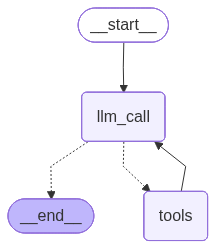

In [ ]:
agent_builder = StateGraph(ScratchpadState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tools", tool_node)
agent_builder.set_entry_point("llm_call")
agent_builder.add_edge("tools", "llm_call")
agent_builder.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", END: END}
)

graph = agent_builder.compile()
graph

In [ ]:
async def run_agent_example():
    # Initial state
    initial_state = ScratchpadState(
        messages=[
            HumanMessage(
                content="What are the impacts of the Israel-Gaza war on children's mental well-being?"
            )
        ],
        scratchpad="",
    )

    # Run the agent
    result = await graph.ainvoke(initial_state)

    format_messages(result["messages"])


asyncio.run(run_agent_example())

2025-10-11 12:34:25 | INFO     | source_formatter:deduplicate_and_format_sources:124 - Processing sources for deduplication and formatting
2025-10-11 12:34:25 | INFO     | source_formatter:deduplicate_and_format_sources:134 - Found 10 unique sources


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the impacts of the Israel-Gaza war on children's mental well-being?                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research the impacts of the Israel-Gaza war on children's mental well-being. Let me start by      │
│ checking my scratchpad for any existing research and then query the retriever tool as my primary knowledge      │
│ source.                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Scratchpad contents:                                                                                            │
│                                                                                                                 │
│ Scratchpad is empty.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me query the retriever tool to find relevant academic and medical research on this topic.               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Research Findings Report                                                                                      │
│ *Generated on October 11, 2025 at 12:33 PM*                                                                     │
│                                                                                                                 │
│ **Summary:**                                                                                                    │
│ - Total unique documents: 4                                                                                     │
│ - Total chunks processed: 6                                                                                     │
│                                                                                                                 │
│ ## Report Statistics                                                                                            │
│                                                                                                                 │
│ - **Total Documents:** 4                                                                                        │
│ - **Total Chunks:** 6                                                                                           │
│                                                                                                                 │
│ ### Documents with Multiple Chunks:                                                                             │
│ - https://www.ncbi.nlm.nih.gov/pubmed/22491534: 2 chunks                                                        │
│ - https://www.ncbi.nlm.nih.gov/pubmed/30702385: 2 chunks                                                        │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Quality of life, primary traumatisation, and positive and negative affects in primary school students in  │
│ the Gaza Strip.                                                                                                 │
│ **Authors:** Veronese Guido, Pepe Alessandro, Almurnak Feda, Jaradah Alaa, Hamdouna Husam                       │
│ **Publication Date:** 2018-Feb-21                                                                               │
│ **URL:** https://www.ncbi.nlm.nih.gov/pubmed/29553411                                                           │
│ **References:** Not available                                                                                   │
│ **Chunks found:** 1                                                                                             │
│                                                                                                                 │
│ ### Content:                                                                                                    │
│                                                                                                                 │
│ **Relevance Score:** 0.9990004121585122                                                                         │
│                                                                                                                 │
│ Article: Quality of life, primary traumatisation, and positive and negative affects in primary school students  │
│ in the Gaza Strip.Many researchers have reported that exposure to war and ongoing political violence increases  │
│ mental health problems in children. Results of studies have also shown a high prevalence (58-80%) of            │
│ post-traumatic stress disorder in war-affected children

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific research on the most recent Israel-Gaza conflicts and their mental health       │
│ impacts on children.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Research Findings Report                                                                                      │
│ *Generated on October 11, 2025 at 12:34 PM*                                                                     │
│                                                                                                                 │
│ **Summary:**                                                                                                    │
│ - Total unique documents: 4                                                                                     │
│ - Total chunks processed: 5                                                                                     │
│                                                                                                                 │
│ ## Report Statistics                                                                                            │
│                                                                                                                 │
│ - **Total Documents:** 4                                                                                        │
│ - **Total Chunks:** 5                                                                                           │
│                                                                                                                 │
│ ### Documents with Multiple Chunks:                                                                             │
│ - https://www.ncbi.nlm.nih.gov/pubmed/22491534: 2 chunks                                                        │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Quality of life, primary traumatisation, and positive and negative affects in primary school students in  │
│ the Gaza Strip.                                                                                                 │
│ **Authors:** Veronese Guido, Pepe Alessandro, Almurnak Feda, Jaradah Alaa, Hamdouna Husam                       │
│ **Publication Date:** 2018-Feb-21                                                                               │
│ **URL:** https://www.ncbi.nlm.nih.gov/pubmed/29553411                                                           │
│ **References:** Not available                                                                                   │
│ **Chunks found:** 1                                                                                             │
│                                                                                                                 │
│ ### Content:                                                                                                    │
│                                                                                                                 │
│ **Relevance Score:** 0.993473961733272                                                                          │
│                                                                                                                 │
│ Article: Quality of life, primary traumatisation, and positive and negative affects in primary school students  │
│ in the Gaza Strip.Many researchers have reported that exposure to war and ongoing political violence increases  │
│ mental health problems in children. Results of studies have also shown a high prevalence (58-80%) of            │
│ post-traumatic stress disorder in war-affected children living in the occupied Palestinian territory. The aim   │
│ of this study was to estimate the direct and indirect e

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for more comprehensive information about the 2023-2024 conflict and its specific impacts on   │
│ children's mental health.                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Sources:                                                                                                        │
│                                                                                                                 │
│ Source 1: Two Years of the Gaza War in Three Health Charts                                                      │
│                                                                                                                 │
│ URL: https://www.thinkglobalhealth.org/article/two-years-of-the-gaza-war-in-three-health-charts                 │
│                                                                                                                 │
│ Most relevant content: ## Two Years of the Gaza War in Three Health Charts # Two Years of the Gaza War in Three │
│ Health Charts Two years after Hamas attacked Israel, the health consequences of the brutal war are sharp This   │
│ week, Gaza ceasefire talks are under way as the brutal war between Hamas and Israel enters its third year. The  │
│ Hamas-led attack on Israel on October 7, 2023, triggered an aggressive ground and air campaign in Gaza, killing │
│ an estimated 5,000 civilians during the first three weeks of war alone, including 1,900 children, according to  │
│ the nonprofit conflict tracker Airwars. #### Attacks on Gaza's Health Care ### Hospital Attacks in Gaza and     │
│ Israel: What Counts as a War Crime?                                                                             │
│                                                                                                                 │
│ Full source content (limited to ~1250 tokens):                                                                  │
│                                                                                                                 │
│ * [Environment](/topic/environment)                                                                             │
│ * [Poverty](/topic/poverty)                                                                                     │
│ * [Trade](/topic/trade)                                                                                         │
│ * [Governance](/topic/governance)                                                                               │
│ * [Food](/topic/food)                                                                                           │
│ * [Urbanization](/topic/urbanization)                                                                           │
│ * [Aging](/topic/aging)                                                                                         │
│ * [Gender](/topic/gender)                                                                                       │
│ * [Migration](/topic/migration)                                                                                 │
│                                                                                                                 │
│ * [Data Visualization](/type/data-visualization)                                                                │
│ * [Recommendations](/type/recommendations)                                                                      │
│ * [Research & Analysis](/type/research-analysis)                                                                │
│ * [Series](/series)                                                                                             │
│ * [Interviews](/type/interviews)                                                                                │
│                                                                                                                 │
│ * [About This Site](/about-site)                                                                                │
│ * [Submission Guidelines](/submission-guidelines)      

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for more specific information about the long-term mental health impacts and interventions.    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Research Findings Report                                                                                      │
│ *Generated on October 11, 2025 at 12:34 PM*                                                                     │
│                                                                                                                 │
│ **Summary:**                                                                                                    │
│ - Total unique documents: 7                                                                                     │
│ - Total chunks processed: 7                                                                                     │
│                                                                                                                 │
│ ## Report Statistics                                                                                            │
│                                                                                                                 │
│ - **Total Documents:** 7                                                                                        │
│ - **Total Chunks:** 7                                                                                           │
│                                                                                                                 │
│ ### Documents with Multiple Chunks:                                                                             │
│ - None (all documents had single chunks)                                                                        │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Quality of life, primary traumatisation, and positive and negative affects in primary school students in  │
│ the Gaza Strip.                                                                                                 │
│ **Authors:** Veronese Guido, Pepe Alessandro, Almurnak Feda, Jaradah Alaa, Hamdouna Husam                       │
│ **Publication Date:** 2018-Feb-21                                                                               │
│ **URL:** https://www.ncbi.nlm.nih.gov/pubmed/29553411                                                           │
│ **References:** Not available                                                                                   │
│ **Chunks found:** 1                                                                                             │
│                                                                                                                 │
│ ### Content:                                                                                                    │
│                                                                                                                 │
│ **Relevance Score:** 0.9967808758971946                                                                         │
│                                                                                                                 │
│ Article: Quality of life, primary traumatisation, and positive and negative affects in primary school students  │
│ in the Gaza Strip.Many researchers have reported that exposure to war and ongoing political violence increases  │
│ mental health problems in children. Results of studies have also shown a high prevalence (58-80%) of            │
│ post-traumatic stress disorder in war-affected children living in the occupied Palestinian territory. The aim   │
│ of this study was to estimate the direct and indirect e

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me organize all this research in my scratchpad and provide a comprehensive answer.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: # RESEARCH ON ISRAEL-GAZA WAR IMPACTS ON CHILDREN'S MENTAL WELL-BEING                      │
│                                                                                                                 │
│ ## PHASE 1: RETRIEVER RESEARCH FINDINGS                                                                         │
│                                                                                                                 │
│ ### Key Studies from Academic Literature:                                                                       │
│                                                                                                                 │
│ 1. **Veronese et al. (2018)** - Quality of life, primary traumatisation, and positive and negative affects in   │
│ primary school students in the Gaza Strip                                                                       │
│    - Sample: 1,276 Palestinian children from primary schools in four refugee camps                              │
│    - Context: 2012 Gaza War                                                                                     │
│    - Key findings: High prevalence (58-80%) of PTSD in war-affected children                                    │
│    - URL: https://www.ncbi.nlm.nih.gov/pubmed/29553411                                                          │
│                                                                                                                 │
│ 2. **Basak (2012)** - The impact of occupation on child health in a Palestinian refugee camp                    │
│    - Sample: 30 in-depth interviews with parents                                                                │
│    - Context: Gaza War December 2008                                                                            │
│    - Key findings: 70% of parents deemed children not in good health pre-war, increased to 100% post-war        │
│    - URL: https://www.ncbi.nlm.nih.gov/pubmed/22491534                                                          │
│                                                                                                                 │
│ 3. **Dalgaard et al. (2019)** - Is silence about trauma harmful for children? Transgenerational communication   │
│ in Palestinian families                                                                                         │
│    - Sample: 170 Palestinian families in Gaza Strip                                                             │
│    - Context: Mixed past traumas and 2008/09 Gaza War                                                           │
│    - Key findings: Family communication about facts, reasons, and meanings associated with lower PTSD in        │
│ children                                                                                                        │
│    - URL: https://www.ncbi.nlm.nih.gov/pubmed/30702385                                                          │
│                                                                                                                 │
│ 4. **Punamäki et al. (2017)** - Family systems approach to attachment relations, war trauma, and mental health  │
│ among Palestinian children and parents                                                                          │
│    - Sample: 325 Palestinian families after 2008-2009 Gaza War                                                  │
│    - Key findings: Identified four family types with different trauma responses                                 │
│    - URL: https://www.ncbi.nlm.nih.gov/pubmed/29844884                                                          │
│                                                                                                                 │
│ 5. **Leshem et al. (2023)** - Post-traumatic stress in 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my comprehensive research, I can now provide you with a detailed analysis of the impacts of the        │
│ Israel-Gaza war on children's mental well-being.                                                                │
│                                                                                                                 │
│ # The Devastating Impacts of the Israel-Gaza War on Children's Mental Well-being                                │
│                                                                                                                 │
│ ## Overview                                                                                                     │
│                                                                                                                 │
│ The Israel-Gaza conflicts, particularly the recent 2023-2024 war, have had catastrophic effects on children's   │
│ mental health across the region. The scale and severity of psychological trauma affecting children is           │
│ unprecedented, with both Palestinian and Israeli children suffering profound mental health consequences.        │
│                                                                                                                 │
│ ## Prevalence of Mental Health Disorders                                                                        │
│                                                                                                                 │
│ ### Post-Traumatic Stress Disorder (PTSD)                                                                       │
│ - **Historical data**: Studies from previous conflicts (2008-2014) showed PTSD prevalence rates of **58-80%**   │
│ among Palestinian children exposed to war trauma (Veronese et al., 2018)                                        │
│ - **Current conflict**: Recent studies show alarmingly high rates:                                              │
│   - **71.3%** of university students reported high PTSD symptom severity (Amro et al., 2025)                    │
│   - **63.4%** of medical students met criteria for PTSD diagnosis (Aldabbour et al., 2024)                      │
│                                                                                                                 │
│ ### Depression, Anxiety, and Stress                                                                             │
│ - **Depression**: 97.05% of young adults showed depressive symptoms (Aldabbour et al., 2024)                    │
│ - **Anxiety**: 84.37% reported anxiety symptoms                                                                 │
│ - **Stress**: 90.56% experienced stress symptoms                                                                │
│                                                                                                                 │
│ ## Key Risk Factors and Trauma Exposure                                                                         │
│                                                                                                                 │
│ ### Direct Trauma Exposure                                                                                      │
│ - **Violence exposure**: Children have witnessed mass casualties, with over **14,500 Palestinian children       │
│ killed** and **1,900 children killed in the first three weeks alone** (UN Report, 2025; Think Global Health,    │
│ 2025)                                                                                                           │
│ - **Loss and displacement**:                                                                                    │
│   - **990,000 Palestinian children displaced** in Gaza                                                          │
│   - **17,000 unaccompanied or separated children**     

# Report Generation

In [ ]:
class Section(BaseModel):
    name: str = Field(
        description="Medical research section title reflecting PubMed study focus (e.g., 'Pediatric Mental Health Outcomes', 'Conflict-Related Injuries', 'Public Health Impact')"
    )
    description: str = Field(
        description="Medical research context explaining what peer-reviewed evidence this section will analyze"
    )
    research: bool = Field(
        description="True if requires current PubMed literature search, systematic reviews, or specific clinical studies. False only for background/methodology sections"
    )
    content: str = Field(
        description="Specific medical evidence requirements: study types needed (RCTs, cohort studies, case reports), population focus, clinical outcomes, or epidemiological data"
    )

    audience_complexity: str = Field(
        description="Medical evidence level: 'clinical_practitioners', 'public_health_officials', 'medical_researchers', or 'policy_makers'",
        default="clinical_practitioners",
    )

    estimated_length: str = Field(
        description="Evidence depth: 'brief', 'standard', or 'comprehensive'",
        default="standard",
    )

    dependencies: list[str] = Field(
        description="Sections that must precede this one for proper medical context",
        default_factory=list,
    )

    success_criteria: str = Field(
        description="Specific medical research outcome or evidence synthesis goal",
        default="",
    )


class Sections(BaseModel):
    sections: list[Section] = Field(
        description="Medical literature review sections following systematic review or evidence synthesis structure"
    )

    total_estimated_length: str = Field(
        description="Medical review scope: 'rapid_review', 'systematic_review', or 'comprehensive_meta_analysis'",
        default="systematic_review",
    )

    primary_audience: str = Field(
        description="Target medical audience: 'clinicians', 'public_health_officials', 'researchers', 'humanitarian_workers', or 'policy_makers'",
        default="clinicians",
    )

    narrative_strategy: str = Field(
        description="Medical research approach: 'systematic_review', 'scoping_review', 'epidemiological_analysis', or 'clinical_evidence_synthesis'",
        default="systematic_review",
    )

In [ ]:
structured_llm = llm.with_structured_output(Sections)
result = structured_llm.invoke("Impact of the Gaza war on children")
result

Sections(sections=[Section(name='Pediatric Mortality and Morbidity', description='Analysis of direct conflict-related child deaths, injuries, and trauma in Gaza', research=True, content='Requires epidemiological data on child mortality rates, injury patterns (blast injuries, shrapnel wounds, burns), and trauma statistics from recent conflict periods. Need peer-reviewed studies, hospital records, and humanitarian organization reports.', audience_complexity='medical_researchers', estimated_length='comprehensive', dependencies=[], success_criteria='Quantitative assessment of direct conflict impact on child survival'), Section(name='Mental Health and Psychosocial Impact', description="Evidence on PTSD, anxiety, depression, and developmental trauma in Gaza's pediatric population", research=True, content='Systematic review of mental health studies, PTSD prevalence, trauma-related disorders, and psychosocial interventions. Need longitudinal studies, clinical assessments, and validated screeni